In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
##
## 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
## 2. Using CNN structure to extract geometry features (characteristics)
## 3. The time interval used to train is revolution 10 to 11.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=400 # Number of filters (kernels) in Convolutional layer
n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# The number of revolution
t_lower = 10 # Lower limit of the interval of time
t_upper = 11 # Upper limit of the interval of time

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
# Case number: NACA 0018 without Gurney flap - case 0
# the others, which are Case 1,2,4,5,7,8,13,14,15,16,17,18,19,20,21

In [6]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [7]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [8]:
t_interval = 0.001
t_len = int((t_upper-t_lower) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps

In [9]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-8],]
n_data = len(cm_target) # Number of txt files from which the aerodynamic coefficients are extracted
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [11]:
cm_target

['case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_time = t
    x_coord = total_coords.reshape((t_len,2,55,1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x_time: ", x_time.shape)
    print("Dimension - x_coordinates: ", x_coord.shape)
    print("Dimension - y: ", y.shape)
    
    return x_time, x_coord, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        cm_beUsed = cm[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
## AeroCNN-1: coordinates are replaced with grid data of 2*50 shape.
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    baseline_coord_high = data.iloc[0,:] # 1*50
    baseline_coord_low = data.iloc[1,:] # 1*50
    baseline_coord = np.vstack((baseline_coord_high, baseline_coord_low)).reshape((2,-1)) # 2*50
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j, betaValue in enumerate(beta):
            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    # flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords = np.vstack((flap_left, flap_right))
    flap_coords2 = np.zeros((n_cases*2,5))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x_time, x_coord, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (1000, 2)
Dimension - airfoil coordinates:  (2000, 50)
Dimension - coord with flaps:  (2000, 5)
Dimension - total coordinates:  (2000, 55)
Dimension - x_time:  (1000, 1)
Dimension - x_coordinates:  (1000, 2, 55, 1)
Dimension - y:  (1000, 1)


In [21]:
# x[:,0] -= 10
# x[:,0] /= 5
x_time -= 10

In [22]:
def dataset_split(x_time, x_coord, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_time_all, x_time_test, x_coord_all, x_coord_test, y_all, y_test, cm_all, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_time_train, x_time_val, x_coord_train, x_coord_val, y_train, y_val, cm_train, cm_val = train_test_split(x_time_all, x_coord_all, y_all, cm_all,
                                                                                                                  test_size=val_rate/(1-test_rate),
                                                                                                                  random_state=kwargs.get('random_state'))
        return x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test

In [23]:
x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x_time,x_coord, y, cm, test_rate, val_rate=val_rate,
                                                                                                                                                   validation=True, random_state=50)

In [24]:
def make_aerocnn1_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_time = tf.keras.Input(shape=1)
    input_coord = tf.keras.Input(shape=(2,55,1))
    
    # The convolutional layer
    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1,
                                     padding='same', activation='relu',
                                     name='convLayer')(input_coord)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)
    
    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_time])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_time, input_coord], output_data)
    
    return model

In [25]:
model = make_aerocnn1_model(num_layer=n_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 400)   2000        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 400)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 10800)        0           ['max_pooling2d[0][0]']          
                                                                                              

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20230102\\Case15"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20230102unsteady_AeroCNN1_Case15_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_kernels)+ "kernels_" +str(n_layers)+"FClayers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_time_train)//batch_size
VALIDATION_STEPS = len(x_time_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit([x_time_train, x_coord_train], y_train, batch_size=batch_size,
                    validation_data=[[x_time_val, x_coord_val], y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/3 [=========>....................] - ETA: 7s - loss: 0.1998 - rmse: 0.4468
Epoch 1: val_loss improved from inf to 0.19644, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 4s 232ms/step - loss: 0.2034 - rmse: 0.4509 - val_loss: 0.1964 - val_rmse: 0.4430 - lr: 1.0000e-04
Epoch 2/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.2298 - rmse: 0.4792
Epoch 2: val_loss improved from 0.19644 to 0.18860, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 93ms/step - loss: 0.2157 - rmse: 0.4643 - val_loss: 0.1886 - val_rmse: 0.4341 - lr: 1.0000e-04
Epoch 3/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.1503 - rmse: 0.3876
Epoch 3: val_loss improved from 0.18860 to 0.17775, saving model to D:

Epoch 50/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0576 - rmse: 0.2396
Epoch 50: val_loss did not improve from 0.05622
3/3 [==============================] - 0s 23ms/step - loss: 0.0580 - rmse: 0.2406 - val_loss: 0.0563 - val_rmse: 0.2369 - lr: 1.0000e-04
Epoch 51/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0575 - rmse: 0.2395
Epoch 51: val_loss did not improve from 0.05622
3/3 [==============================] - 0s 22ms/step - loss: 0.0557 - rmse: 0.2357 - val_loss: 0.0562 - val_rmse: 0.2368 - lr: 1.0000e-04
Epoch 52/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0668 - rmse: 0.2582
Epoch 52: val_loss did not improve from 0.05622
3/3 [==============================] - 0s 22ms/step - loss: 0.0608 - rmse: 0.2462 - val_loss: 0.0562 - val_rmse: 0.2368 - lr: 1.0000e-04
Epoch 53/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0602 - rmse: 0.2450
Epoch 53: val_loss did not improve from 0.05622
3/3 [========================

3/3 [==============================] - 0s 98ms/step - loss: 0.0615 - rmse: 0.2476 - val_loss: 0.0558 - val_rmse: 0.2360 - lr: 1.0000e-04
Epoch 75/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0524 - rmse: 0.2285
Epoch 75: val_loss improved from 0.05584 to 0.05580, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 103ms/step - loss: 0.0534 - rmse: 0.2308 - val_loss: 0.0558 - val_rmse: 0.2359 - lr: 1.0000e-04
Epoch 76/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0622 - rmse: 0.2491
Epoch 76: val_loss improved from 0.05580 to 0.05577, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 100ms/step - loss: 0.0587 - rmse: 0.2420 - val_loss: 0.0558 - val_rmse: 0.2358 - lr: 1.0000e-04
Epoch 77/10000


3/3 [==============================] - 0s 90ms/step - loss: 0.0547 - rmse: 0.2336 - val_loss: 0.0531 - val_rmse: 0.2302 - lr: 1.0000e-04
Epoch 118/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0549 - rmse: 0.2339
Epoch 118: val_loss improved from 0.05314 to 0.05296, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 121ms/step - loss: 0.0536 - rmse: 0.2312 - val_loss: 0.0530 - val_rmse: 0.2298 - lr: 1.0000e-04
Epoch 119/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0559 - rmse: 0.2361
Epoch 119: val_loss improved from 0.05296 to 0.05275, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 109ms/step - loss: 0.0561 - rmse: 0.2366 - val_loss: 0.0527 - val_rmse: 0.2293 - lr: 1.0000e-04
Epoch 120/1

Epoch 139/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0460 - rmse: 0.2141
Epoch 139: val_loss did not improve from 0.04840
3/3 [==============================] - 0s 36ms/step - loss: 0.0497 - rmse: 0.2225 - val_loss: 0.0484 - val_rmse: 0.2197 - lr: 1.0000e-04
Epoch 140/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0419 - rmse: 0.2044
Epoch 140: val_loss improved from 0.04840 to 0.04759, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 99ms/step - loss: 0.0489 - rmse: 0.2208 - val_loss: 0.0476 - val_rmse: 0.2178 - lr: 1.0000e-04
Epoch 141/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0468 - rmse: 0.2161
Epoch 141: val_loss improved from 0.04759 to 0.04723, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [===

Epoch 159/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0409 - rmse: 0.2019
Epoch 159: val_loss improved from 0.03884 to 0.03829, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 102ms/step - loss: 0.0408 - rmse: 0.2016 - val_loss: 0.0383 - val_rmse: 0.1953 - lr: 1.0000e-04
Epoch 160/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0406 - rmse: 0.2011
Epoch 160: val_loss improved from 0.03829 to 0.03792, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 118ms/step - loss: 0.0372 - rmse: 0.1925 - val_loss: 0.0379 - val_rmse: 0.1944 - lr: 1.0000e-04
Epoch 161/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0396 - rmse: 0.1986
Epoch 161: val_loss did not improve from 0.03792
3/3 [=

3/3 [==============================] - 0s 120ms/step - loss: 0.0244 - rmse: 0.1558 - val_loss: 0.0242 - val_rmse: 0.1550 - lr: 1.0000e-04
Epoch 180/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0288 - rmse: 0.1692
Epoch 180: val_loss improved from 0.02417 to 0.02413, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 129ms/step - loss: 0.0270 - rmse: 0.1640 - val_loss: 0.0241 - val_rmse: 0.1549 - lr: 1.0000e-04
Epoch 181/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0246 - rmse: 0.1564
Epoch 181: val_loss did not improve from 0.02413
3/3 [==============================] - 0s 37ms/step - loss: 0.0262 - rmse: 0.1613 - val_loss: 0.0245 - val_rmse: 0.1562 - lr: 1.0000e-04
Epoch 182/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0207 - rmse: 0.1435
Epoch 182: val_loss improved from 0.02413 to 0.02155, saving mod

Epoch 201/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0050 - rmse: 0.0696
Epoch 201: val_loss improved from 0.00480 to 0.00452, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 101ms/step - loss: 0.0046 - rmse: 0.0668 - val_loss: 0.0045 - val_rmse: 0.0661 - lr: 1.0000e-04
Epoch 202/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0054 - rmse: 0.0728
Epoch 202: val_loss did not improve from 0.00452
3/3 [==============================] - 0s 38ms/step - loss: 0.0049 - rmse: 0.0691 - val_loss: 0.0057 - val_rmse: 0.0747 - lr: 1.0000e-04
Epoch 203/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0057 - rmse: 0.0745
Epoch 203: val_loss improved from 0.00452 to 0.00379, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==

1/3 [=========>....................] - ETA: 0s - loss: 5.5531e-04 - rmse: 0.0202
Epoch 250: val_loss improved from 0.00109 to 0.00106, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 117ms/step - loss: 0.0010 - rmse: 0.0294 - val_loss: 0.0011 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 251/10000
1/3 [=========>....................] - ETA: 0s - loss: 9.3950e-04 - rmse: 0.0281
Epoch 251: val_loss did not improve from 0.00106
3/3 [==============================] - 0s 35ms/step - loss: 0.0011 - rmse: 0.0305 - val_loss: 0.0011 - val_rmse: 0.0304 - lr: 1.0000e-04
Epoch 252/10000
1/3 [=========>....................] - ETA: 0s - loss: 0.0012 - rmse: 0.0321
Epoch 252: val_loss did not improve from 0.00106
3/3 [==============================] - 0s 34ms/step - loss: 0.0011 - rmse: 0.0304 - val_loss: 0.0011 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 253/10000
1/3 [===

3/3 [==============================] - 0s 102ms/step - loss: 6.7104e-04 - rmse: 0.0229 - val_loss: 6.6142e-04 - val_rmse: 0.0227 - lr: 1.0000e-04
Epoch 297/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.6767e-04 - rmse: 0.0205
Epoch 297: val_loss did not improve from 0.00066
3/3 [==============================] - 0s 38ms/step - loss: 7.1534e-04 - rmse: 0.0239 - val_loss: 6.6899e-04 - val_rmse: 0.0229 - lr: 1.0000e-04
Epoch 298/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.4694e-04 - rmse: 0.0173
Epoch 298: val_loss did not improve from 0.00066
3/3 [==============================] - 0s 38ms/step - loss: 6.4423e-04 - rmse: 0.0223 - val_loss: 6.7515e-04 - val_rmse: 0.0230 - lr: 1.0000e-04
Epoch 299/10000
1/3 [=========>....................] - ETA: 0s - loss: 8.0191e-04 - rmse: 0.0256
Epoch 299: val_loss did not improve from 0.00066
3/3 [==============================] - 0s 34ms/step - loss: 6.3368e-04 - rmse: 0.0221 - val_loss: 7.1030e-04 - val_rmse: 0.023

Epoch 322/10000
1/3 [=========>....................] - ETA: 0s - loss: 7.7770e-04 - rmse: 0.0251
Epoch 322: val_loss improved from 0.00058 to 0.00055, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 79ms/step - loss: 6.2873e-04 - rmse: 0.0220 - val_loss: 5.4811e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 323/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.9318e-04 - rmse: 0.0187
Epoch 323: val_loss improved from 0.00055 to 0.00054, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 67ms/step - loss: 5.8878e-04 - rmse: 0.0211 - val_loss: 5.3830e-04 - val_rmse: 0.0198 - lr: 1.0000e-04
Epoch 324/10000
1/3 [=========>....................] - ETA: 0s - loss: 5.7022e-04 - rmse: 0.0206
Epoch 324: val_loss did not i

Epoch 346/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.7106e-04 - rmse: 0.0181
Epoch 346: val_loss did not improve from 0.00044
3/3 [==============================] - 0s 24ms/step - loss: 4.5179e-04 - rmse: 0.0175 - val_loss: 4.4515e-04 - val_rmse: 0.0173 - lr: 1.0000e-04
Epoch 347/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.5633e-04 - rmse: 0.0146
Epoch 347: val_loss improved from 0.00044 to 0.00043, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 71ms/step - loss: 3.9158e-04 - rmse: 0.0157 - val_loss: 4.3490e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 348/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.8162e-04 - rmse: 0.0154
Epoch 348: val_loss improved from 0.00043 to 0.00043, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256

Epoch 371/10000
1/3 [=========>....................] - ETA: 0s - loss: 4.2067e-04 - rmse: 0.0167
Epoch 371: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 25ms/step - loss: 4.0053e-04 - rmse: 0.0160 - val_loss: 3.7153e-04 - val_rmse: 0.0151 - lr: 1.0000e-04
Epoch 372/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.0329e-04 - rmse: 0.0126
Epoch 372: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 25ms/step - loss: 3.4953e-04 - rmse: 0.0144 - val_loss: 3.8515e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 373/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.6931e-04 - rmse: 0.0150
Epoch 373: val_loss did not improve from 0.00037
3/3 [==============================] - 0s 26ms/step - loss: 3.8759e-04 - rmse: 0.0156 - val_loss: 4.3537e-04 - val_rmse: 0.0171 - lr: 1.0000e-04
Epoch 374/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.1159e-04 - rmse: 0.0130
Epoch 374: val_loss did not im

Epoch 419/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.9001e-04 - rmse: 0.0122
Epoch 419: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 35ms/step - loss: 2.6479e-04 - rmse: 0.0111 - val_loss: 2.6716e-04 - val_rmse: 0.0112 - lr: 1.0000e-04
Epoch 420/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.2018e-04 - rmse: 0.0089
Epoch 420: val_loss did not improve from 0.00027
3/3 [==============================] - 0s 35ms/step - loss: 2.4512e-04 - rmse: 0.0102 - val_loss: 2.6728e-04 - val_rmse: 0.0112 - lr: 1.0000e-04
Epoch 421/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4711e-04 - rmse: 0.0103
Epoch 421: val_loss improved from 0.00027 to 0.00026, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 101ms/step - loss: 2.5150e-04 - rmse: 0.0105 - val_loss: 2.6358e-04 - val_rmse: 0.01

Epoch 445/10000
1/3 [=========>....................] - ETA: 0s - loss: 3.4161e-04 - rmse: 0.0142
Epoch 445: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 2.8811e-04 - rmse: 0.0122 - val_loss: 3.1516e-04 - val_rmse: 0.0132 - lr: 1.0000e-04
Epoch 446/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.8827e-04 - rmse: 0.0122
Epoch 446: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 21ms/step - loss: 2.5663e-04 - rmse: 0.0108 - val_loss: 2.5412e-04 - val_rmse: 0.0107 - lr: 1.0000e-04
Epoch 447/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.5270e-04 - rmse: 0.0106
Epoch 447: val_loss did not improve from 0.00025
3/3 [==============================] - 0s 22ms/step - loss: 2.8431e-04 - rmse: 0.0120 - val_loss: 2.5071e-04 - val_rmse: 0.0105 - lr: 1.0000e-04
Epoch 448/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.3305e-04 - rmse: 0.0096
Epoch 448: val_loss did not im

Epoch 497/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.4587e-04 - rmse: 0.0104
Epoch 497: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 25ms/step - loss: 2.2258e-04 - rmse: 0.0092 - val_loss: 2.0326e-04 - val_rmse: 0.0081 - lr: 1.0000e-04
Epoch 498/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8533e-04 - rmse: 0.0069
Epoch 498: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 24ms/step - loss: 2.1761e-04 - rmse: 0.0089 - val_loss: 2.1444e-04 - val_rmse: 0.0087 - lr: 1.0000e-04
Epoch 499/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9148e-04 - rmse: 0.0073
Epoch 499: val_loss did not improve from 0.00020
3/3 [==============================] - 0s 24ms/step - loss: 2.0810e-04 - rmse: 0.0084 - val_loss: 2.3248e-04 - val_rmse: 0.0097 - lr: 1.0000e-04
Epoch 500/10000
1/3 [=========>....................] - ETA: 0s - loss: 2.1917e-04 - rmse: 0.0090
Epoch 500: val_loss did not im

3/3 [==============================] - 0s 74ms/step - loss: 1.8234e-04 - rmse: 0.0067 - val_loss: 1.8316e-04 - val_rmse: 0.0068 - lr: 1.0000e-04
Epoch 524/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8305e-04 - rmse: 0.0068
Epoch 524: val_loss did not improve from 0.00018
3/3 [==============================] - 0s 25ms/step - loss: 1.8743e-04 - rmse: 0.0071 - val_loss: 1.8612e-04 - val_rmse: 0.0070 - lr: 1.0000e-04
Epoch 525/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7645e-04 - rmse: 0.0063
Epoch 525: val_loss improved from 0.00018 to 0.00018, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 71ms/step - loss: 1.8027e-04 - rmse: 0.0066 - val_loss: 1.8254e-04 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 526/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6497e-04 - rmse: 0.0053
Epoch 526: val_loss improved f

Epoch 577/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8356e-04 - rmse: 0.0070
Epoch 577: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 26ms/step - loss: 1.7466e-04 - rmse: 0.0063 - val_loss: 1.7788e-04 - val_rmse: 0.0066 - lr: 1.0000e-04
Epoch 578/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7103e-04 - rmse: 0.0060
Epoch 578: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 26ms/step - loss: 1.6813e-04 - rmse: 0.0058 - val_loss: 1.8678e-04 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 579/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7677e-04 - rmse: 0.0065
Epoch 579: val_loss did not improve from 0.00017
3/3 [==============================] - 0s 24ms/step - loss: 1.8927e-04 - rmse: 0.0074 - val_loss: 1.8241e-04 - val_rmse: 0.0069 - lr: 1.0000e-04
Epoch 580/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7455e-04 - rmse: 0.0063
Epoch 580: val_loss improved f

Epoch 603/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6891e-04 - rmse: 0.0059
Epoch 603: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 25ms/step - loss: 1.6603e-04 - rmse: 0.0057 - val_loss: 1.7415e-04 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 604/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6140e-04 - rmse: 0.0052
Epoch 604: val_loss improved from 0.00016 to 0.00016, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 79ms/step - loss: 1.7930e-04 - rmse: 0.0067 - val_loss: 1.5989e-04 - val_rmse: 0.0051 - lr: 1.0000e-04
Epoch 605/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6028e-04 - rmse: 0.0051
Epoch 605: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 27ms/step - loss: 1.6965e-04 - rmse: 0.0060 - val_loss: 1.8341e-04 - val_rmse: 0.007

Epoch 630/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5375e-04 - rmse: 0.0046
Epoch 630: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 26ms/step - loss: 1.5922e-04 - rmse: 0.0051 - val_loss: 1.6985e-04 - val_rmse: 0.0061 - lr: 1.0000e-04
Epoch 631/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6902e-04 - rmse: 0.0060
Epoch 631: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 24ms/step - loss: 1.6226e-04 - rmse: 0.0054 - val_loss: 1.6429e-04 - val_rmse: 0.0056 - lr: 1.0000e-04
Epoch 632/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6882e-04 - rmse: 0.0060
Epoch 632: val_loss did not improve from 0.00016
3/3 [==============================] - 0s 25ms/step - loss: 1.6536e-04 - rmse: 0.0057 - val_loss: 1.8388e-04 - val_rmse: 0.0072 - lr: 1.0000e-04
Epoch 633/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7148e-04 - rmse: 0.0062
Epoch 633: val_loss did not im

1/3 [=========>....................] - ETA: 0s - loss: 1.6051e-04 - rmse: 0.0055
Epoch 685: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 26ms/step - loss: 1.6071e-04 - rmse: 0.0055 - val_loss: 1.7527e-04 - val_rmse: 0.0067 - lr: 1.0000e-04
Epoch 686/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6001e-04 - rmse: 0.0054
Epoch 686: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 26ms/step - loss: 1.6903e-04 - rmse: 0.0062 - val_loss: 1.9434e-04 - val_rmse: 0.0080 - lr: 1.0000e-04
Epoch 687/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8697e-04 - rmse: 0.0075
Epoch 687: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 25ms/step - loss: 1.7171e-04 - rmse: 0.0064 - val_loss: 1.6986e-04 - val_rmse: 0.0063 - lr: 1.0000e-04
Epoch 688/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.6168e-04 - rmse: 0.0056
Epoch 688: val_loss did not improve from 0.000

3/3 [==============================] - 0s 79ms/step - loss: 1.6771e-04 - rmse: 0.0062 - val_loss: 1.4638e-04 - val_rmse: 0.0041 - lr: 1.0000e-04
Epoch 713/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4964e-04 - rmse: 0.0045
Epoch 713: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 26ms/step - loss: 1.7863e-04 - rmse: 0.0070 - val_loss: 1.5333e-04 - val_rmse: 0.0049 - lr: 1.0000e-04
Epoch 714/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5141e-04 - rmse: 0.0047
Epoch 714: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 26ms/step - loss: 1.7428e-04 - rmse: 0.0067 - val_loss: 2.2143e-04 - val_rmse: 0.0096 - lr: 1.0000e-04
Epoch 715/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.9625e-04 - rmse: 0.0082
Epoch 715: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 25ms/step - loss: 2.0117e-04 - rmse: 0.0085 - val_loss: 2.4789e-04 - val_rmse: 0.0109

Epoch 741/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.8182e-04 - rmse: 0.0073
Epoch 741: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 26ms/step - loss: 1.6875e-04 - rmse: 0.0064 - val_loss: 1.5339e-04 - val_rmse: 0.0050 - lr: 1.0000e-04
Epoch 742/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.5042e-04 - rmse: 0.0047
Epoch 742: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 26ms/step - loss: 1.7245e-04 - rmse: 0.0066 - val_loss: 1.8696e-04 - val_rmse: 0.0077 - lr: 1.0000e-04
Epoch 743/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7316e-04 - rmse: 0.0067
Epoch 743: val_loss did not improve from 0.00015
3/3 [==============================] - 0s 25ms/step - loss: 1.7700e-04 - rmse: 0.0070 - val_loss: 1.9111e-04 - val_rmse: 0.0079 - lr: 1.0000e-04
Epoch 744/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.7956e-04 - rmse: 0.0072
Epoch 744: val_loss did not im

3/3 [==============================] - 0s 78ms/step - loss: 1.4157e-04 - rmse: 0.0037 - val_loss: 1.4295e-04 - val_rmse: 0.0039 - lr: 5.0000e-05
Epoch 768/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3997e-04 - rmse: 0.0035
Epoch 768: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 91ms/step - loss: 1.4013e-04 - rmse: 0.0036 - val_loss: 1.4089e-04 - val_rmse: 0.0037 - lr: 5.0000e-05
Epoch 769/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4141e-04 - rmse: 0.0037
Epoch 769: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 27ms/step - loss: 1.4014e-04 - rmse: 0.0036 - val_loss: 1.4207e-04 - val_rmse: 0.0038 - lr: 5.0000e-05
Epoch 770/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4310e-04 - rmse: 0.0040
Epoch 770: val_loss did not im

Epoch 794/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3863e-04 - rmse: 0.0034
Epoch 794: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 27ms/step - loss: 1.3593e-04 - rmse: 0.0030 - val_loss: 1.4399e-04 - val_rmse: 0.0041 - lr: 5.0000e-05
Epoch 795/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4958e-04 - rmse: 0.0048
Epoch 795: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 25ms/step - loss: 1.4471e-04 - rmse: 0.0042 - val_loss: 1.4213e-04 - val_rmse: 0.0039 - lr: 5.0000e-05
Epoch 796/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4418e-04 - rmse: 0.0042
Epoch 796: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 25ms/step - loss: 1.4158e-04 - rmse: 0.0038 - val_loss: 1.4682e-04 - val_rmse: 0.0045 - lr: 5.0000e-05
Epoch 797/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4013e-04 - rmse: 0.0036
Epoch 797: val_loss did not im

Epoch 821/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3832e-04 - rmse: 0.0034
Epoch 821: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 27ms/step - loss: 1.3665e-04 - rmse: 0.0032 - val_loss: 1.3839e-04 - val_rmse: 0.0035 - lr: 5.0000e-05
Epoch 822/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4534e-04 - rmse: 0.0043
Epoch 822: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 26ms/step - loss: 1.4021e-04 - rmse: 0.0037 - val_loss: 1.4059e-04 - val_rmse: 0.0038 - lr: 5.0000e-05
Epoch 823/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3503e-04 - rmse: 0.0029
Epoch 823: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 25ms/step - loss: 1.3498e-04 - rmse: 0.0029 - val_loss: 1.3982e-04 - val_rmse: 0.0037 - lr: 5.0000e-05
Epoch 824/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3729e-04 - rmse: 0.0033
Epoch 824: val_loss improved f

Epoch 848/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3585e-04 - rmse: 0.0031
Epoch 848: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 25ms/step - loss: 1.3551e-04 - rmse: 0.0031 - val_loss: 1.3910e-04 - val_rmse: 0.0036 - lr: 5.0000e-05
Epoch 849/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3432e-04 - rmse: 0.0029
Epoch 849: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 26ms/step - loss: 1.3611e-04 - rmse: 0.0032 - val_loss: 1.3781e-04 - val_rmse: 0.0035 - lr: 5.0000e-05
Epoch 850/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3460e-04 - rmse: 0.0029
Epoch 850: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 26ms/step - loss: 1.3499e-04 - rmse: 0.0030 - val_loss: 1.3804e-04 - val_rmse: 0.0035 - lr: 5.0000e-05
Epoch 851/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3960e-04 - rmse: 0.0037
Epoch 851: val_loss did not im

3/3 [==============================] - 0s 26ms/step - loss: 1.3533e-04 - rmse: 0.0031 - val_loss: 1.3679e-04 - val_rmse: 0.0034 - lr: 2.5000e-05
Epoch 875/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3404e-04 - rmse: 0.0029
Epoch 875: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 25ms/step - loss: 1.3517e-04 - rmse: 0.0031 - val_loss: 1.3618e-04 - val_rmse: 0.0033 - lr: 2.5000e-05
Epoch 876/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3232e-04 - rmse: 0.0026
Epoch 876: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 25ms/step - loss: 1.3402e-04 - rmse: 0.0029 - val_loss: 1.3749e-04 - val_rmse: 0.0035 - lr: 2.5000e-05
Epoch 877/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3734e-04 - rmse: 0.0034
Epoch 877: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256u

3/3 [==============================] - 0s 72ms/step - loss: 1.3348e-04 - rmse: 0.0029 - val_loss: 1.3575e-04 - val_rmse: 0.0032 - lr: 2.5000e-05
Epoch 902/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.4063e-04 - rmse: 0.0039
Epoch 902: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 88ms/step - loss: 1.3596e-04 - rmse: 0.0033 - val_loss: 1.3571e-04 - val_rmse: 0.0032 - lr: 2.5000e-05
Epoch 903/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3401e-04 - rmse: 0.0030
Epoch 903: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 73ms/step - loss: 1.3402e-04 - rmse: 0.0030 - val_loss: 1.3566e-04 - val_rmse: 0.003

Epoch 926/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3255e-04 - rmse: 0.0028
Epoch 926: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 27ms/step - loss: 1.3421e-04 - rmse: 0.0030 - val_loss: 1.3541e-04 - val_rmse: 0.0032 - lr: 2.5000e-05
Epoch 927/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3383e-04 - rmse: 0.0030
Epoch 927: val_loss did not improve from 0.00014
3/3 [==============================] - 0s 26ms/step - loss: 1.3348e-04 - rmse: 0.0029 - val_loss: 1.3553e-04 - val_rmse: 0.0033 - lr: 2.5000e-05
Epoch 928/10000
1/3 [=========>....................] - ETA: 0s - loss: 1.3462e-04 - rmse: 0.0031
Epoch 928: val_loss improved from 0.00014 to 0.00014, saving model to D:\TrainedModels\20230102\Case1520230102unsteady_AeroCNN1_Case15_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
3/3 [==============================] - 0s 84ms/step - loss: 1.3400e-04 - rmse: 0.0030 - val_loss: 1.3516e-04 - val_rmse: 0.003

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:01:44.468318


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20230102_AeroCNN1_Case13_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_kernels)+"kernels_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

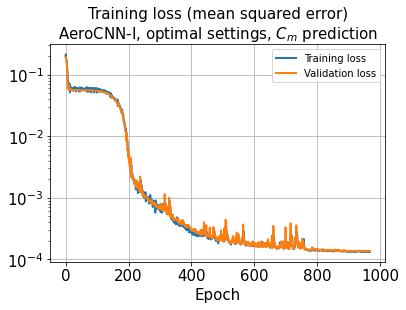

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

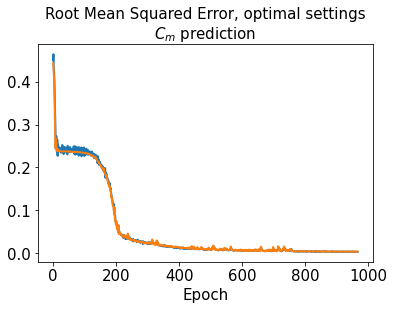

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

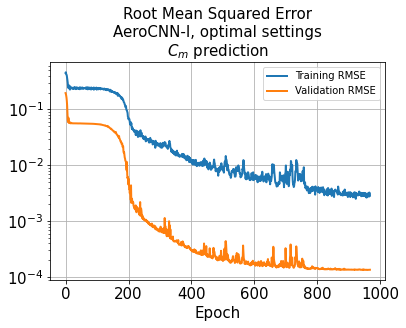

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate([x_time_train, x_coord_train], y_train)

22/22 [==============================] - 0s 8ms/step - loss: 1.3938e-04 - rmse: 0.0034


In [37]:
val_results = model.evaluate([x_time_val, x_coord_val], y_val)

7/7 [==============================] - 0s 10ms/step - loss: 1.4089e-04 - rmse: 0.0037


In [38]:
test_results = model.evaluate([x_time_test, x_coord_test], y_test)

4/4 [==============================] - 0s 14ms/step - loss: 1.4593e-04 - rmse: 0.0043


In [39]:
decoded_train_ = model.predict([x_time_train, x_coord_train])
decoded_val_ = model.predict([x_time_val, x_coord_val])
decoded_test_ = model.predict([x_time_test, x_coord_test])

4/4 [==============================] - 0s 3ms/step


In [40]:
def define_index(y_total, y_partial):
    return np.unique(np.where(np.isin(y_total, y_partial)))

In [41]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [42]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [43]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real) * np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real + y_pred)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.007555383315804375
0.285272643906697


In [46]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.008152241550502428
0.32105457641467094


In [47]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.008166531758332292
0.26996062996809855


In [48]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [49]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [50]:
model_directory = "D:\\TrainedModels\\20230102"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221230unsteady_AeroCNN1_Case15_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels)+"kernels_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [52]:
os.chdir(storage_dir)

In [53]:
l2_error_train_list = []
for i in range(0, len(x_time_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_val_list = []
for i in range(0, len(x_time_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(x_time_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [56]:
mape_train_list = []
for i in range(0, len(x_time_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [57]:
mape_val_list = []
for i in range(0, len(x_time_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [58]:
mape_test_list = []
for i in range(0, len(x_time_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [59]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

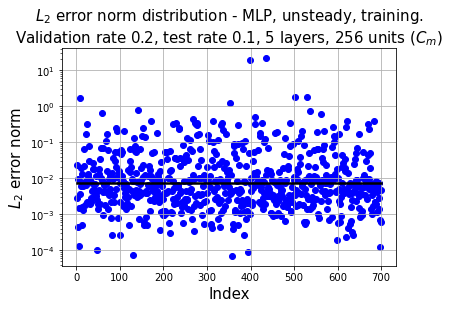

In [60]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

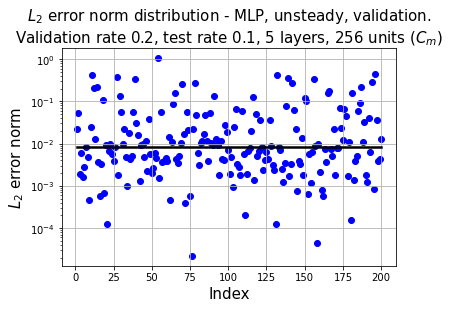

In [61]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

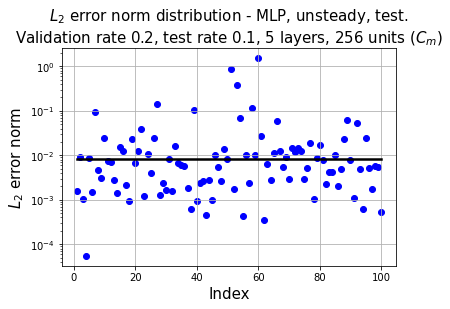

In [62]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [63]:
predicted = model.predict([x_time, x_coord])

32/32 [==============================] - 0s 4ms/step


In [64]:
tTrain = x_time[index_train] + 10
tVal = x_time[index_val] + 10
tTest = x_time[index_test] + 10

In [65]:
max(predicted)

array([0.9989935], dtype=float32)

In [66]:
print(l2_error(predicted, y))

0.007752121860396466


In [67]:
# Each set of data in sorted order
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [68]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [69]:
t

array([[0.   ],
       [0.001],
       [0.002],
       [0.003],
       [0.004],
       [0.005],
       [0.006],
       [0.007],
       [0.008],
       [0.009],
       [0.01 ],
       [0.011],
       [0.012],
       [0.013],
       [0.014],
       [0.015],
       [0.016],
       [0.017],
       [0.018],
       [0.019],
       [0.02 ],
       [0.021],
       [0.022],
       [0.023],
       [0.024],
       [0.025],
       [0.026],
       [0.027],
       [0.028],
       [0.029],
       [0.03 ],
       [0.031],
       [0.032],
       [0.033],
       [0.034],
       [0.035],
       [0.036],
       [0.037],
       [0.038],
       [0.039],
       [0.04 ],
       [0.041],
       [0.042],
       [0.043],
       [0.044],
       [0.045],
       [0.046],
       [0.047],
       [0.048],
       [0.049],
       [0.05 ],
       [0.051],
       [0.052],
       [0.053],
       [0.054],
       [0.055],
       [0.056],
       [0.057],
       [0.058],
       [0.059],
       [0.06 ],
       [0.061],
       [

In [70]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [71]:
x_time += 10

L2 error of Cm: 0.0078


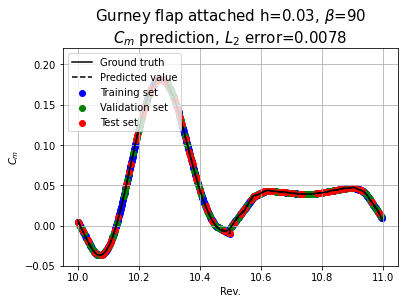

In [72]:
h = [0.03]
beta = [90]
for i in range(0,1):
    #Index from each dataset in sorted order
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [73]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0078


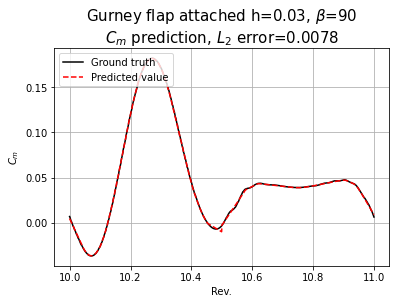

In [74]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0078


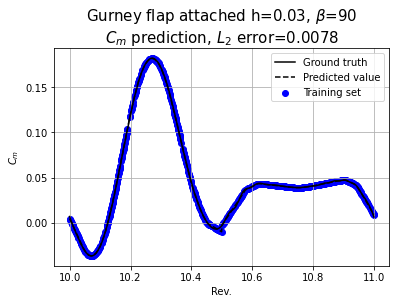

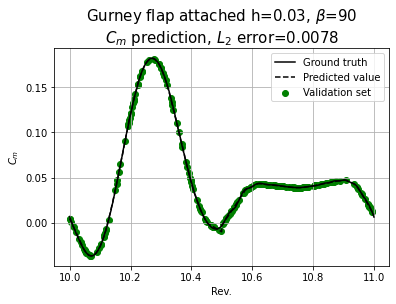

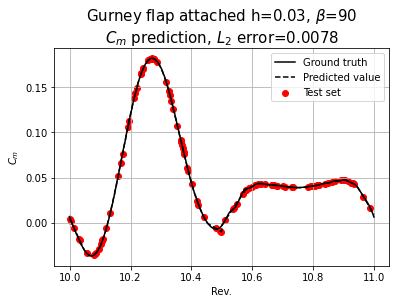

In [75]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)

    # Cm graph plot
    ## Training dataset
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Validation dataset
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Test dataset
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()